# Ribosome Profile Simulator

This script is used to create simulated ribosome profiles from scratch. The simulation works by drawing a set of elongation rates from a gamma distribution and then plugging those rates into the equations from the inhomogenous l-TASEP model in order to create estimations of ribosome density across the transcript. These distributions of ribosome density are then randomly sampled from in order to create the equivalent of 

In [1]:
# Let the program know where to find your tools file.
import sys
sys.path.append('/home/keeganfl/Desktop/Work_Fall_2021/Fall_2021_Work_journal/tools/')

In [202]:
# Import necessary packages
from plastid import BAMGenomeArray, VariableFivePrimeMapFactory, \
                        GTF2_TranscriptAssembler, GFF3_TranscriptAssembler, \
                        Transcript, ThreePrimeMapFactory, CenterMapFactory
from plastid.plotting.plots import *
import numpy as np
import os
from Bio import SeqIO
import numpy
import math
import pandas as pd
from statsmodels.stats.proportion import proportions_ztest
from scipy import stats
import keegan_analysis_tools as kat
from statsmodels.nonparametric.smoothers_lowess import lowess
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
import csv
import random
from matplotlib.pyplot import figure
from scipy.sparse.linalg import lsqr
from multiprocess import Pool
from tqdm import tqdm

In [3]:
image_path = '/home/keeganfl/Desktop/Work_Fall_2021/Presentation_figures/'

## define functions

In [4]:
def big_dif(diff_dist, data_mutant, data_control, figsize = (16,50), fontsize = 12, stat_name = "ks_stat ="):
    '''
    A function which creates a large graph showing the profile arrays for a list of transcripts
    
    returns a matplotlib axis object. 
    '''
    fig,ax = plt.subplots(len(diff_dist), 2, figsize = figsize)
    for axi, stat, gi in zip(ax, diff_dist, diff_dist.index):
            my_vec_mutant = data_mutant[gi]
            my_vec_control = data_control[gi]
            maxi = max([max(my_vec_mutant), max(my_vec_control)])*1.1

            axi[0].plot(my_vec_mutant)
            axi[0].text(len(my_vec_mutant)/2, maxi/1.2, stat_name + str(stat), fontsize = fontsize)
            axi[0].set_ylim([0,maxi])
            axi[0].set_ylabel("Read Counts", fontsize = fontsize)
            axi[0].set_xlabel("Codon Position", fontsize = fontsize)
            axi[0].set_title("mutant " + str(gi), fontsize = fontsize)
            axi[1].plot(my_vec_control)
            axi[1].set_ylim([0,maxi])
            axi[1].set_ylabel("Read Counts", fontsize = fontsize)
            axi[1].set_xlabel("Codon Position", fontsize = fontsize)
            axi[1].set_title("control " + str(gi), fontsize = fontsize)
    fig.tight_layout()
            
    return ax

In [5]:
def split_equal(value, parts):
    value = float(value)
    return [i*value/parts for i in range(1,parts+1)]

In [6]:
def determine_sim_enrichment(ks_table, N_cats, max_ks):
    ratios = []
    all_ks = ks_table
    ks_MC = ks_table[ks_table["phase_mutant"] == "MC"]
    sections = split_equal(max_ks, N_cats)
    ratios.append(len(ks_MC.ks_stat[ks_MC.ks_stat < sections[0]])/len(all_ks.ks_stat[all_ks.ks_stat < sections[0]]))
    for sec, i in zip(sections, list(range(len(sections)))):
        try:
            ratios.append(len(ks_MC.ks_stat[(ks_MC.ks_stat > sec) & (ks_MC.ks_stat < sections[i+1])]
                )/len(all_ks.ks_stat[(all_ks.ks_stat > sec) & (all_ks.ks_stat < sections[i+1])]))
        except:
            pass
    ratios.append(len(ks_MC.ks_stat[ks_MC.ks_stat > sections[-1]])/len(all_ks.ks_stat[all_ks.ks_stat > sections[-1]]))
    return ratios, sections

In [7]:
def det_p_values(ks_table, sections):
    p_values = []
    all_ks = ks_table
    ks_MC = ks_table[ks_table["phase_mutant"] == "MC"]
    for sec, i in zip(sections, list(range(len(sections)))):
        try:
            obs = len(ks_MC.ks_stat[(ks_MC.ks_stat > sec) & (ks_MC.ks_stat < sections[i + 1])])
            all_p = len(all_ks.ks_stat[(all_ks.ks_stat > sec) & (all_ks.ks_stat < sections[i + 1])])
            p_v = proportions_ztest(obs, all_p, len(ks_MC)/len(all_ks))[1]
            p_values.append(p_v)
        except:
            pass
    obs = len(ks_MC.ks_stat[ks_MC.ks_stat > sections[-1]])
    all_p = len(all_ks.ks_stat[all_ks.ks_stat > sections[-1]])
    p_v = proportions_ztest(obs, all_p, len(ks_MC)/len(all_ks))[1]
    p_values.append(p_v)
    return p_values

In [8]:
def low_density(lamb,a,I = 10):
    '''
    A function that calculates the particle density along a transcript from a set of elongation rates
    inferred from ribosome profiling. This function assumes that elongation is in a low density regime
    (e.g. initiation limiting)
    '''
    Jl = (a*(lamb[0]-a))/(lamb[0] + (I-1)*a)
    pl = 1/(2*I) + (Jl*(I-1))/(2*I*lamb) - np.sqrt((1/(2*I) + (Jl*(I-1))/(2*I*lamb))**2 - Jl/(I*lamb))
    return pl, Jl 

def high_density(lamb,B,I = 10):
    '''
    A function that calculates the particle density along a transcript from a set of elongation rates
    inferred from ribosome profiling. This function assumes that elongation is in a high density regime
    (e.g. termination limiting)
    '''
    JR = (B*(lamb[-1]-B))/(lamb[-1] + (I-1)*B)
    pR = 1/(2*I) + (JR*(I-1))/(2*I*lamb) + np.sqrt((1/(2*I) + (JR*(I-1))/(2*I*lamb))**2 - JR/(I*lamb))
    return pR, JR

def maximum_current(lamb,a,B,I = 10):
    '''
    A function that calculates the particle density along a transcript from a set of elongation rates
    inferred from ribosome profiling. This function assumes that elongation is in a maximum current regime
    (e.g. elongation limiting)
    '''
    Jmax = min(lamb)/((1+np.sqrt(I))**2)
    flip = np.where(lamb == np.amin(lamb))[0][0]
    pR = 1/(2*I) + (Jmax*(I-1))/(2*I*lamb[0:flip]) + np.sqrt((1/(2*I) + (Jmax*(I-1))/(
        2*I*lamb[0:flip]))**2 - Jmax/(I*lamb[0:flip]))
    pl = 1/(2*I) + (Jmax*(I-1))/(2*I*lamb[flip:]) - np.sqrt((1/(2*I) + (Jmax*(I-1))/(
        2*I*lamb[flip:]))**2 - Jmax/(I*lamb[flip:]))
    p = np.concatenate((pR,pl))
    return p, Jmax

def make_mc(arr_c, position, a, B, I = 10):
    '''
    This function purposefully induces elongation limitation at a certain point 
    '''
    lamb_c = copy.deepcopy(arr_c)
    Jmax = min(lamb_c)/((1+np.sqrt(I))**2)
    crit_a = ((lamb_c[0] - (I-1) * Jmax) / 2)*(1 - np.sqrt(1 - (4*lamb_c[0]*Jmax)/((lamb_c[0] - (I - 1)*Jmax)**2)))
    crit_B = ((lamb_c[-1] - (I-1) * Jmax) / 2)*(1 - np.sqrt(1 - (4*lamb_c[-1]*Jmax)/((lamb_c[-1] - (I - 1)*Jmax)**2)))
    mut_min = position
    while True:
        lamb_c[mut_min] = lamb_c[mut_min]*0.9 # It keeps doing this every run through. 
        Jmax = min(lamb_c)/((1+np.sqrt(I))**2)
        crit_a = ((lamb_c[0] - (I-1) * Jmax) / 2)*(1 - np.sqrt(1 - (4*lamb_c[0]*Jmax)/((lamb_c[0] - (I - 1)*Jmax)**2)))
        crit_B = ((lamb_c[-1] - (I-1) * Jmax) / 2)*(1 - np.sqrt(1 - (4*lamb_c[-1]*Jmax)/((lamb_c[-1] - (I - 1)*Jmax)**2)))
        if crit_a < a and crit_B < B:
            break
    p, J = maximum_current(lamb_c,a=a,B=B,I = 10)
    return p, J

####!!!!#### If I am going to keep this function I better do something about the possibility of a high density regime.
def make_ld(lamb, a, B, I = 10):
    '''
    This function attempts to 
    '''
    lamb_c = copy.deepcopy(lamb)# Create a copy of lamb to work on. 
    Jmax = min(lamb_c)/((1+np.sqrt(I))**2)
    crit_a = ((lamb_c[0] - (I-1) * Jmax) / 2)*(1 - np.sqrt(1 - (4*lamb_c[0]*Jmax)/((lamb_c[0] - (I - 1)*Jmax)**2)))
    crit_B = ((lamb_c[-1] - (I-1) * Jmax) / 2)*(1 - np.sqrt(1 - (4*lamb_c[-1]*Jmax)/((lamb_c[-1] - (I - 1)*Jmax)**2)))
    if a < crit_a and B > crit_B:
        p, J = low_density(lamb_c, a, I)
    else:
        while True:
            min_l = np.where(lamb_c == np.amin(lamb_c))[0][0]
            lamb_c[min_l] = lamb_c[min_l]*1.1 # It keeps doing this every run through. 
            Jmax = min(lamb_c)/((1+np.sqrt(I))**2)
            crit_a = ((lamb_c[0] - (I-1) * Jmax) / 2)*(1 - np.sqrt(1 - (4*lamb_c[0]*Jmax)/((lamb_c[0] - (I - 1)*Jmax)**2)))
            crit_B = ((lamb_c[-1] - (I-1) * Jmax) / 2)*(1 - np.sqrt(1 - (4*lamb_c[-1]*Jmax)/((lamb_c[-1] - (I - 1)*Jmax)**2)))
            if a < crit_a and B > crit_B:
                break
        p, J = low_density(lamb_c, a, I) 
    return p, J

def get_density(lamb, a, B, I = 10, intermediates = False):
    '''A function that determines the correct elongation  regime/phase and calculates the correct density 
       accordingly
       
       arg lamb: A set of elongation rates for each codon in a transcript
       type: list of floats
       
       arg a: An initiation rate (the rate at which ribosomes are added to the transcript)
       type: float
       
       arg B: A termination rate (the rate a which ribosomes leave the transcript)
       type: float
       
       arg I: The particle size to be used in the TASEP model (should equal the size of the ribosome in codons)
       type: int
       
       arg intermediates: If set to true than the function will output all intermediate values used to calculate densities
       type: bool 
    
    '''
    lamb_c = copy.deepcopy(lamb)# Create a copy of lamb to work on. 
    Jmax = min(lamb_c)/((1+np.sqrt(I))**2)
    crit_a = ((lamb_c[0] - (I-1) * Jmax) / 2)*(1 - np.sqrt(1 - (4*lamb_c[0]*Jmax)/((lamb_c[0] - (I - 1)*Jmax)**2)))
    crit_B = ((lamb_c[-1] - (I-1) * Jmax) / 2)*(1 - np.sqrt(1 - (4*lamb_c[-1]*Jmax)/((lamb_c[-1] - (I - 1)*Jmax)**2)))
    if a < crit_a and B > crit_B:
        p, J = low_density(lamb_c, a, I)
        phase = "LD"
    elif a > crit_a and B < crit_B:
        p, J = high_density(lamb_c, B, I)
        phase = "HD"
    elif a < crit_a and B < crit_B:
        Jl = (a*(lamb[0]-a))/(lamb[0] + (I-1)*a)
        JR = (B*(lamb[-1]-B))/(lamb[-1] + (I-1)*B)
        sign = Jl - JR 
        if sign > 0:
            p, J = low_density(lamb_c, a, I)
            phase = "LD"
        elif sign < 0:
            p, J = high_density(lamb_c, B, I)
            phase = "HD"
    elif a > crit_a and B > crit_B:
        p, J = maximum_current(lamb_c, a, B, I)
        phase = "MC"
    if intermediates == False:
        return p, J, phase
    elif intermediates == True:
        return p, J, phase, a, B, crit_a, crit_B, min(lamb_c), lamb_c[0], lamb_c[-1]

In [192]:
def get_all_intermediates(mean_lambda = 4, sd = 3, min_lambda = 0.8, length = 400, a = 0.02, B = 2, read_density = 1, pause_N = 4, 
                     pause_str = 0.5, a_frac = 1.0, rng_a = False, rng_pause = False, rng_p_range = (0.1, 0.8),
                     rng_a_range = (0.25,2), elon_frac = 1):
    '''
    A function that simulates ribosome profiling data from a mutant and a control for a single gene. 
    
    mean_lambda: The mean elongation rate used for the simulated gene
    type: float
    
    sd: The standard deviation of the elongation rates for your simulated gene
    type: float
    
    length: The length of your simulated gene
    type: int
    
    a: The initiation rate of your simulated gene
    type: float
    
    B: The termination rate of your simulated gene
    type: float
    
    read_density: how many reads should be extracted from your simulated gene per codon. 
    type: int
    
    pause_N: An integer specifying the number of pauses you want to induce in the mutant. Note that all 
             pause sites are induced in the first half of the transcript.
    type: int
    
    pause_str: The fraction by which to change the elongation rates at the pause sites in the mutant.
    type: float
    
    a_frac: The fraction by which to change the initiation rates in the mutant
    
    rng_a: If this parameter is set to True then the fraction by which to change the initiation rates in the mutant
           will be chosen randomly from a range of possible fractions specified in "rng_a_range" rather than being a single value. 
    type: boolean
    
    rng_pause: If this parameter is set to True then the fraction by which to change the elongation rates at the pause sites in the mutant.
               will be chosen randomly from a range of possible fractions specified in "rng_p_range" rather than being a single value. 
    type: boolean
    
    rng_p_range: A range of values from which the pause strength of the pause sites will be selected from
    type: tuple of length 2
    
    rng_a_range: A range of values from which the change to the alpha value for the mutant will be selected from
    type: tuple of length 2
    
    elon_frac: The fraction by which to change the global elongation rates in the mutant. 
    type: float
    
    '''
    mean_sqr = np.sqrt(mean_lambda)
    sample_size = int(read_density * length)
    lamb_c = np.random.gamma(mean_sqr, sd, length) + min_lambda 
    lamb_m = copy.deepcopy(lamb_c)
        
    # Create a set of random pause sights in your mutant. 
    pause_sites = np.random.randint(10, length/2, pause_N)
    if rng_pause == True:
        for ps in pause_sites:
            lamb_m[ps] = lamb_m[ps]* np.random.uniform(rng_p_range[0], rng_p_range[1], 1)[0]
    else:
        for ps in pause_sites:
            lamb_m[ps] = lamb_m[ps]*pause_str

    # alter the initiation rate of the mutant 
    if rng_a == True:
        mu_a = a* np.random.uniform(rng_a_range[0], rng_a_range[1], 1)[0]
    else:
        mu_a = a*a_frac
        
    # alter the elongation rate of the mutant
    lamb_m = lamb_m*elon_frac
    
    # simulate the reads for the control
    p_c, J_c, phase_c, a_c, B_c, crit_a_c, crit_B_c, min_l_c, ini_l_c, term_l_c = get_density(lamb_c, a, B, intermediates = True)
    prob_c = p_c/sum(p_c)
    reads_c = np.zeros(length)
    for i in range(sample_size):
        x = numpy.random.choice(np.arange(0, len(prob_c)), p = prob_c)
        reads_c[x] = reads_c[x]+1

    # simulate the reads for the mutant assuming LD
    mu_a = a* np.random.uniform(0.25, 2, 1)[0]
    p_m, J_m, phase_m, a_m, B_m, crit_a_m, crit_B_m, min_l_m, ini_l_m, term_l_m = get_density(lamb_m, mu_a, B, intermediates = True)
    prob_m = p_m/sum(p_m)
    reads_m = np.zeros(length)
    for i in range(sample_size):
        x = np.random.choice(np.arange(0, len(prob_m)), p = prob_m)
        reads_m[x] = reads_m[x]+1
    return(reads_c, J_c, phase_c, a_c, B_c, crit_a_c, crit_B_c, min_l_c, ini_l_c, term_l_c, reads_m, J_m, phase_m, a_m, B_m, 
           crit_a_m, crit_B_m, min_l_m, ini_l_m, term_l_m)

In [227]:
# Create a function to automate the simulation process
def simulate_profile(mean_lambda = 4, sd = 3, min_lambda = 0.8, length = 400, a = 0.02, B = 2, read_density = 1, pause_density = 0.01, 
                     pause_str = 0.5, a_frac = 1.0, rng_a = False, rng_pause = False, rng_p_range = (0.1, 0.8),
                     rng_a_range = (0.25,2), elon_frac = 1, return_min_lam = False):
    '''
    A function that simulates ribosome profiling data from a mutant and a control for a single gene. 
    
    mean_lambda: The mean elongation rate used for the simulated gene
    type: float
    
    sd: The standard deviation of the elongation rates for your simulated gene
    type: float
    
    length: The length of your simulated gene
    type: int
    
    a: The initiation rate of your simulated gene
    type: float
    
    B: The termination rate of your simulated gene
    type: float
    
    read_density: how many reads should be extracted from your simulated gene per codon. 
    type: int
    
    pause_N: An integer specifying the number of pauses you want to induce in the mutant. Note that all 
             pause sites are induced in the first half of the transcript.
    type: int
    
    pause_str: The fraction by which to change the elongation rates at the pause sites in the mutant.
    type: float
    
    a_frac: The fraction by which to change the initiation rates in the mutant
    
    rng_a: If this parameter is set to True then the fraction by which to change the initiation rates in the mutant
           will be chosen randomly from a range of possible fractions specified in "rng_a_range" rather than being a single value. 
    type: boolean
    
    rng_pause: If this parameter is set to True then the fraction by which to change the elongation rates at the pause sites in the mutant.
               will be chosen randomly from a range of possible fractions specified in "rng_p_range" rather than being a single value. 
    type: boolean
    
    rng_p_range: A range of values from which the pause strength of the pause sites will be selected from
    type: tuple of length 2
    
    rng_a_range: A range of values from which the change to the alpha value for the mutant will be selected from
    type: tuple of length 2
    
    elon_frac: The fraction by which to change the global elongation rates in the mutant. 
    type: float
    
    '''
    
    mean_sqr = np.sqrt(mean_lambda)
    sample_size = int(read_density * length)
    lamb_c = np.random.gamma(mean_sqr, sd, length)+ min_lambda 
    lamb_m = copy.deepcopy(lamb_c)
        
    # Create a set of random pause sights in your mutant. 
    pause_sites = []
    for i in range(round(length/2)):
        if random.random() < pause_density:
            pause_sites.append(i)
    if rng_pause == True:
        for ps in pause_sites:
            lamb_m[ps] = lamb_m[ps]* np.random.uniform(rng_p_range[0], rng_p_range[1], 1)[0]
    else:
        for ps in pause_sites:
            lamb_m[ps] = lamb_m[ps]*pause_str

    # alter the initiation rate of the mutant 
    if rng_a == True:
        mu_a = a* np.random.uniform(rng_a_range[0], rng_a_range[1], 1)[0]
    else:
        mu_a = a*a_frac
        
    # alter the elongation rate of the mutant
    lamb_m = lamb_m*elon_frac
        
    # Simulate the reads for the control
    p_c, J_c, phase_c = get_density(lamb_c, a, B)
    prob_c = p_c/sum(p_c)
    reads_c = np.zeros(length)
    for i in range(sample_size):
        x = numpy.random.choice(np.arange(0, len(prob_c)), p = prob_c)
        reads_c[x] = reads_c[x]+1
        
    # simulate the reads for the mutant
    p_m, J_m, phase_m = get_density(lamb_m, mu_a, B)
    prob_m = p_m/sum(p_m)
    reads_m = np.zeros(length)
    for i in range(sample_size):
        x = np.random.choice(np.arange(0, len(prob_m)), p = prob_m)
        reads_m[x] = reads_m[x]+1
    if return_min_lam == False:
        return reads_c, J_c, phase_c, reads_m, J_m, phase_m
    elif return_min_lam == True:
        return reads_c, J_c, phase_c, min(lamb_c), reads_m, J_m, phase_m, min(lamb_m)

Just showing that the KS statistic works? 

Pick randomly and then decrease by a specific factor rather than a random factor. different levels, start with decreasing. 

Experiment with doing different read densities. 

Ok, basically do the proportion table thing for several different read densities to show that the KS-statistic can pick up on these differences no matter what. Do I want to set it up so that it creates a list of densities as well?

## Draw random samples from your particle densities

In [257]:
# Create a large number of simulations
data_control = []
j_control = []
phase_control = []
min_control = []
data_mutant = []
j_mutant = []
phase_mutant = []
min_mutant = []
for i in range(2000):
    length = numpy.random.randint(200,2500)
    #alpha = numpy.random.uniform(0.004,0.02)
    alpha = 0.01
    x = simulate_profile(mean_lambda = 4, sd = 3, length = length, a= alpha, B = 2, read_density = 0.5, pause_density = 0.01, pause_str = 0.16, 
                         a_frac = 1, elon_frac = 1, return_min_lam = True)
    data_control.append(x[0])
    j_control.append(x[1])
    phase_control.append(x[2])
    min_control.append(x[3])
    data_mutant.append(x[4])
    j_mutant.append(x[5])
    phase_mutant.append(x[6])
    min_mutant.append(x[7])

## Calculate Smoothed Vector Arrays

In [258]:
# Define the maximum number of processors that can be used when creating the smoothed vector arrays
max_pool = 20

# get smoothed vector arrays for all of the control data.
with Pool(max_pool) as p:
    pool_control = list(
         tqdm(
            p.imap(kat.get_smoothed_vector_parallel,
                      data_control),
            total=len(data_control)
        )
    )    

100%|███████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 77.30it/s]


In [259]:
# get smoothed vector arrays for all of the mutant data.
with Pool(max_pool) as p:
    pool_mutant = list(
        tqdm(
            p.imap(kat.get_smoothed_vector_parallel,
                       data_mutant),
            total=len(data_mutant)
        )
    )    

100%|███████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 76.76it/s]


## Determine KS statistic for all transcripts

In [260]:
# Find the correlation between all of the controls and the samples.
# Note that many of the lowest values spring from very short transcripts or transcripts with few reads. 
ks_list = []
len_list = []
id_list = []
x = -1
for tr_m, tr_c, index in zip(data_mutant, data_control, list(range(len(data_mutant)))):
    x = x+1
    position = np.array(list(range(len(tr_m))))
    smoothed_vec_m, cumul_m = pool_mutant[index]
    smoothed_vec_c, cumul_c = pool_control[index]
    ks = max(abs(cumul_m - cumul_c))
    ks_list.append(ks)
    len_list.append(len(tr_m))
    id_list.append(x)
            
# reorganizing the lists into a dataframe. 
df_b = pd.DataFrame(list(zip(ks_list, j_control, j_mutant, phase_control, phase_mutant, min_control, min_mutant, len_list, id_list)))
df_b.columns = ["ks_stat","J_control", "J_mutant","phase_control", "phase_mutant","min_control", "min_mutant", "gene_length", "id"]
#df_b.to_csv(save_path + "ks_table_" + samp_num + ".csv", index=False)
    
# Clear out unneeded lists
ks_list.clear()
len_list.clear()

In [261]:
df_sorted = df_b.sort_values(by = "ks_stat")

In [262]:
categories = []
for i in df_sorted.phase_mutant:
    if i == "MC":
        categories.append(0)
    elif i == "LD":
        categories.append(1)
    elif i == "HD":
        categories.append(2)
colormap = np.array(['purple','g','b'])

Text(0.5, 1.0, 'KS statistic of all simulated genes')

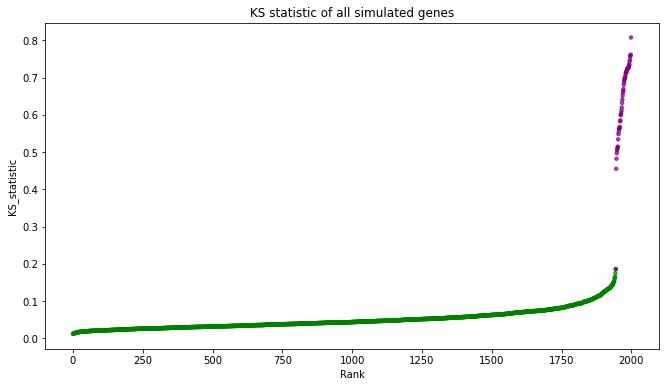

In [263]:
# Plot the KS values for each gene from lowest to highest. 
figure(figsize = (11,6))
plt.scatter(list(range(len(df_b["ks_stat"]))), df_sorted["ks_stat"], s=12, alpha = 0.7, c= colormap[categories]) #ok, this works but I need to sort it first, 
#I can probably just sort the dataframe itself to do this. 
plt.ylabel("KS_statistic")
plt.xlabel("Rank")
plt.title("KS statistic of all simulated genes")

In [160]:
# Create a column in the data frame containing the size group for each gene.
size_groups = []
for i in df_b["gene_length"]:
    if i < 700:
        size_groups.append(1)
    elif i >= 700 and i < 1750:
        size_groups.append(2)
    elif i >= 1750:
        size_groups.append(3)
df_b["size_groups"] = size_groups

In [264]:
# Find all of the transcripts with a KS stat above a certain threshold and group them by gene ID
group = df_b[(df_b['ks_stat'] > 0.15)&(df_b['ks_stat']<0.2)].groupby('id')

# Create a list of all of the unique genes 
diff_dist = group.apply(lambda x: x['ks_stat'].unique())

In [265]:
len(diff_dist)

9

In [266]:
diff_dist.index

Int64Index([69, 148, 372, 395, 483, 648, 822, 1076, 1187], dtype='int64', name='id')

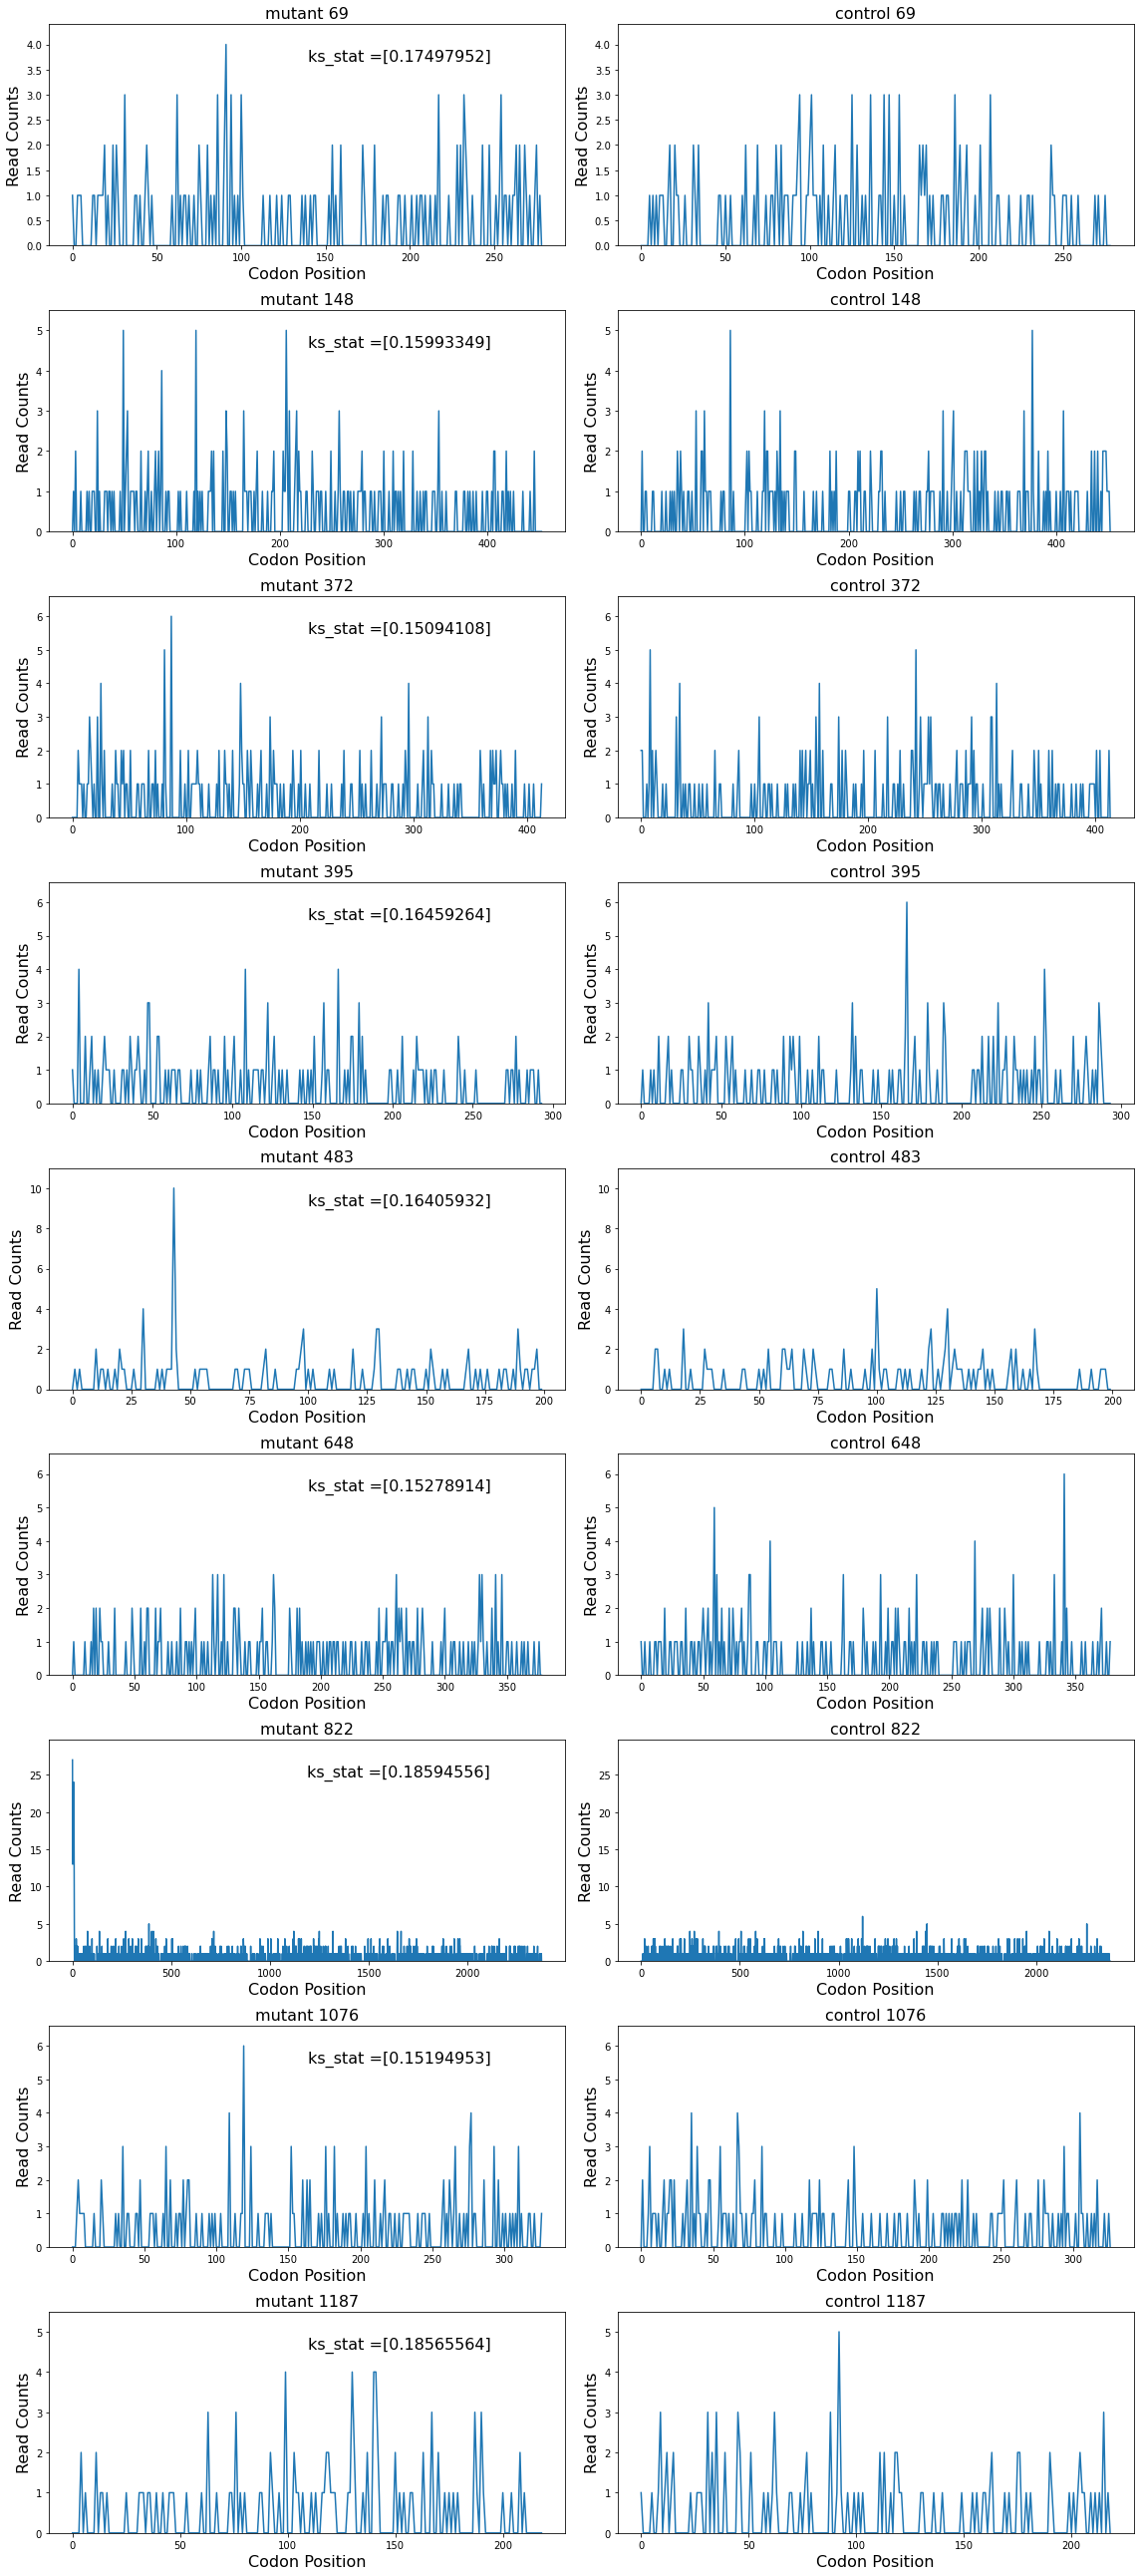

In [267]:
# Look at the smoothed count distributions for each of the transcripts that passed the threshold
ax = big_dif(diff_dist, data_mutant, data_control, figsize = (16,len(diff_dist)*4), fontsize = 16)

In [172]:
ratios, sections = determine_sim_enrichment(df_b, 2, 0.2)

In [173]:
ratios

[0.0, 0.0, 0.9786821705426356]

In [174]:
det_p_values(df_b, sections)

---------------------------------------------------------------------------
RuntimeWarning
divide by zero encountered in double_scalars
in /home/keeganfl/miniconda3/envs/plastid/lib/python3.8/site-packages/statsmodels/stats/weightstats.py, line 790:

788     """
790     zstat = value / std
791     if alternative in ["two-sided", "2-sided", "2s"]:
792         pvalue = stats.norm.sf(np.abs(zstat)) * 2

---------------------------------------------------------------------------


[0.0, 0.0]

Text(0, 0.5, 'KS Statistic')

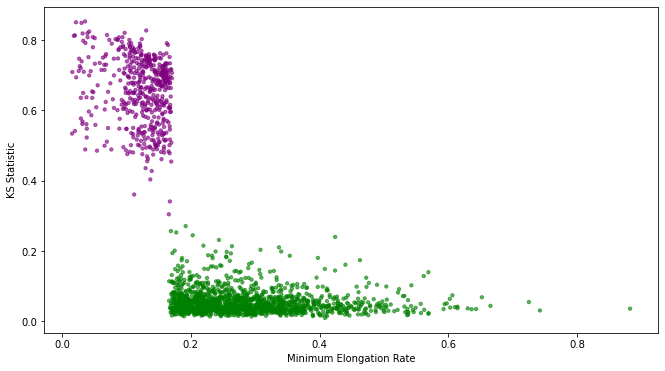

In [178]:
figure(figsize = (11,6))
plt.scatter(df_sorted.min_mutant, df_sorted.ks_stat,c= colormap[categories], s=11, alpha = 0.6)
plt.xlabel("Minimum Elongation Rate")
plt.ylabel("KS Statistic")

## Experimenting with making a phase diagram showing all points. 

In [179]:
# A list of all the outputs. (reads_c, J_c, phase_c, a_c, B_c, crit_a_c, crit_B_c, min_l_c, ini_l_c, term_l_c, reads_m, J_m, phase_m, a_m, B_m, 
#           crit_a_m, crit_B_m, min_l_m, ini_l_m, term_l_m)

In [180]:
data_control = []
data_mutant = []
J_control = []
J_mutant = []
phase_control = []
phase_mutant = []
alphas = []
mu_alphas = []
betas = []
mu_betas = []
crit_alphas = []
crit_betas = []
crit_mu_alphas = []
crit_mu_betas = []
min_lambs = []
mu_min_lambs = []
ini_lambs = []
mu_ini_lambs = []
term_lambs = []
mu_term_lambs = []
for i in range(25):
    length = numpy.random.randint(200,2500)
    alpha = numpy.random.uniform(0.004,0.02)
    x = get_all_intermediates(mean_lambda = 4, sd = 3, length = length, a= alpha, B = 2, read_density = 0.5, pause_N = 7, pause_str = 0.1, 
                         a_frac = 1, elon_frac = 1)
    data_control.append(x[0])
    J_control.append(x[1])
    phase_control.append(x[2])
    alphas.append(x[3])
    betas.append(x[4])
    crit_alphas.append(x[5])
    crit_betas.append(x[6])
    min_lambs.append(x[7])
    ini_lambs.append(x[8])
    term_lambs.append(x[9])
    data_mutant.append(x[10])
    J_mutant.append(x[11])
    phase_mutant.append(x[12])
    mu_alphas.append(x[13])
    mu_betas.append(x[14])
    crit_mu_alphas.append(x[15])
    crit_mu_betas.append(x[16])
    mu_min_lambs.append(x[17])
    mu_ini_lambs.append(x[18])
    mu_term_lambs.append(x[19])

In [181]:
np.where((np.array(alphas)/np.array(crit_alphas) == np.amax((np.array(alphas)/np.array(crit_alphas)))))

(array([13]),)

Set an arbitrary termination rate (say that termination rate does not have an effect on this process). 

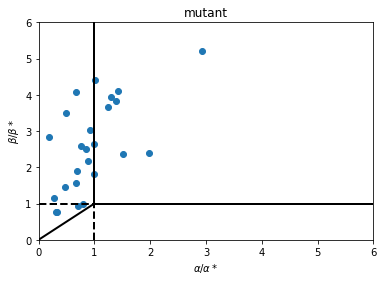

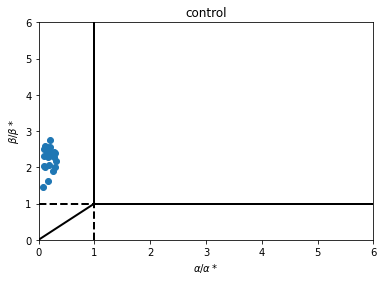

In [183]:
plt.scatter((np.array(mu_alphas)/np.array(crit_mu_alphas)), (np.array(mu_betas)/np.array(crit_mu_betas))*0.015)
plt.ylim([0,6])
plt.xlim([0,6])
plt.xlabel(r'$\alpha / \alpha*$')
plt.ylabel(r'$\beta / \beta*$')
plt.title("mutant")
plt.plot([1, 1], [1, 10], 'k-', lw=2)
plt.plot([1, 10], [1,1], 'k-', lw = 2)
plt.plot([0, 1], [0,1], 'k-', lw = 2)
plt.plot([0, 1], [1,1], 'k--', lw = 2)
plt.plot([1, 1], [0,1], 'k--', lw = 2)
plt.show()
plt.scatter((np.array(alphas)/np.array(crit_alphas)), (np.array(betas)/np.array(crit_betas))*0.07)
plt.ylim([0,6])
plt.xlim([0,6])
plt.xlabel(r'$\alpha / \alpha*$')
plt.ylabel(r'$\beta / \beta*$')
plt.title("control")
plt.plot([1, 1], [1, 10], 'k-', lw=2)
plt.plot([1, 10], [1,1], 'k-', lw = 2)
plt.plot([0, 1], [0,1], 'k-', lw = 2)
plt.plot([0, 1], [1,1], 'k--', lw = 2)
plt.plot([1, 1], [0,1], 'k--', lw = 2)

In [184]:
from sympy import symbols, solve, sqrt

In [185]:
# create a function that can determine the 
def get_critical(alpha, l1, I = 10):
    lmin = symbols('lmin', positive = True, real = True)
    expr = ((l1 - (I-1) * (lmin/((1+sqrt(I))**2))) / 2)*(1 - sqrt(1 - (4*l1*(lmin/((1+sqrt(I))**2)))/((l1 - (I - 1)*(lmin/((1+sqrt(I))**2)))**2))) - alpha
    sol = solve(expr)
    return sol

In [186]:
ini_lambs[14]

4.6618798316606345

In [187]:
x = get_critical(alphas[14],ini_lambs[14])

In [188]:
ini_lambs[14]/x[0]

21.0084972120414